In [2]:
!pip install ipynb

Device: cuda
Files already downloaded and verified
Epoch [5/50] Batch 781/782                   Loss Discriminator: 1.622, loss Generator: 3.666, FID Score: 309.333 
Epoch [10/50] Batch 781/782                   Loss Discriminator: 0.936, loss Generator: 8.319, FID Score: 308.572 
Epoch [15/50] Batch 781/782                   Loss Discriminator: 1.496, loss Generator: 6.704, FID Score: 318.939 
Epoch [20/50] Batch 781/782                   Loss Discriminator: 0.957, loss Generator: 6.696, FID Score: 313.510 
Epoch [25/50] Batch 781/782                   Loss Discriminator: 0.926, loss Generator: 6.083, FID Score: 297.531 
Epoch [30/50] Batch 781/782                   Loss Discriminator: 2.650, loss Generator: 11.419, FID Score: 287.500 
Epoch [35/50] Batch 781/782                   Loss Discriminator: 0.543, loss Generator: 7.023, FID Score: 291.739 
Epoch [40/50] Batch 781/782                   Loss Discriminator: 0.678, loss Generator: 5.800, FID Score: 314.407 
Epoch [45/50] Batch 7

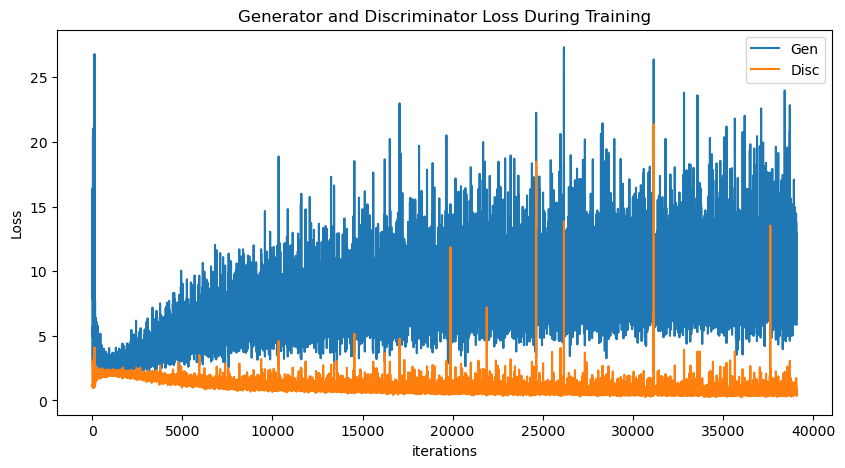

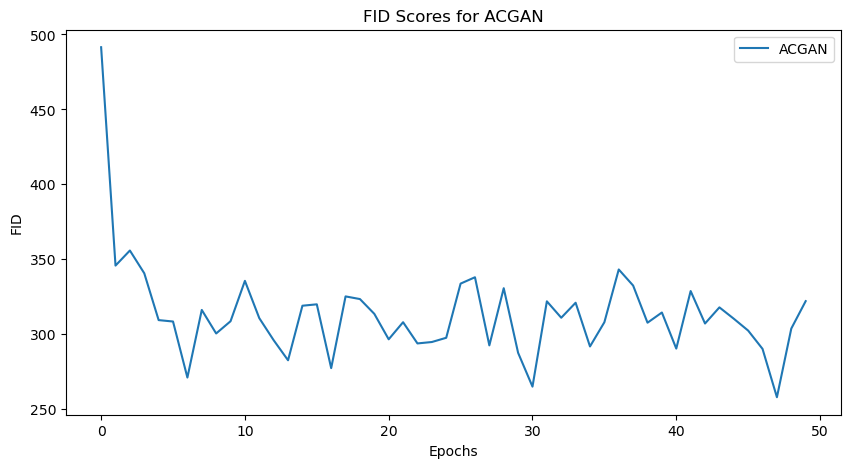

In [4]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from ipynb.fs.full.FID import calculate_fretchet


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
BATCH_SIZE = 64
image_size = 64
channels_img = 3  
noise_dim = 100
max_epochs = 50
disc_features = 64 
gen_features = 64 
num_classes = 10
embed_size = 100
criticItr = 5


dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
                           ]))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)



class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim+embed_size,features_g* 16, 4, 1, 0, bias = False),   
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)
    

    
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label
    

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
            
gen = Generator(num_classes, image_size,embed_size,noise_dim, channels_img, gen_features).to(device)
disc = Discriminator(num_classes, image_size,channels_img, disc_features).to(device)
initialize_weights(gen)
initialize_weights(disc)




fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
step = 0
disOptim = optim.Adam(disc.parameters(),learning_rate, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), learning_rate, betas = (0.5,0.999))
criterion = nn.BCELoss()
counterList = []
counter = 0
genLossList = []
disLossList = []
img_list = []



gen.train() 
disc.train()
GenLoss = []
DiscLoss = []
img_list = []
iters = 0
FID_list = []

# start timing
time_start = time.time() 
for epoch in range(max_epochs):
    epoch = epoch+1
    for batch_idx, (realImg,labels) in enumerate(dataloader):
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()
        
    
        # Train Discriminator 
        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        loss_disc_realVal = criterion(disc_real, r_label)
        discRealLabelLoss = F.nll_loss(disc_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()
        
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, noise_dim, 1, 1).to(device)
        fake = gen(noise,sampleLabel) #genrator img data
        disc_fake, disc_fLabel = disc(fake.detach())
        r_label.fill_(0.0)
        loss_disc_fakelVal = criterion(disc_fake, r_label)
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()
        #avg disc Loss
        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        disOptim.step()
        
        
        # Train Generator 
        gen.zero_grad()
        noise = torch.randn(miniBatch, noise_dim, 1, 1).to(device)
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        r_label.fill_(1.0)
        fake = gen(noise, sampleLabel)
        genOutput, genOutputLabel = disc(fake)
        loss_gen_r = criterion(genOutput, r_label)
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        genOptim.step()
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == max_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise,sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    
    fretchet_dist=calculate_fretchet(real,fake)
    FID_list.append(fretchet_dist)
    if epoch % 5  == 0:
               print(f"Epoch [{epoch}/{max_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ")
        
    
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))




plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('ACGAN_LOSS.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list,label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('ACGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

np.save('ACGAN_FID', FID_list) 